In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import os
import shutil
import json
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
dataset_path = '/content/drive/MyDrive/ngaksara/dataset'
split_dataset_path = '/content/drive/MyDrive/ngaksara/split'

In [ ]:
if os.path.exists(dataset_path):
    print(f"✓ Dataset ditemukan di: {dataset_path}")
    print(f"✓ Jumlah folder kelas: {len(os.listdir(dataset_path))}")
    print(f"✓ Nama kelas: {os.listdir(dataset_path)}")
else:
    print(f"✗ Dataset tidak ditemukan di: {dataset_path}")
    print("Pastikan Anda sudah mount Drive dan path benar!")

✓ Dataset ditemukan di: /content/drive/MyDrive/ngaksara/dataset
✓ Jumlah folder kelas: 30
✓ Nama kelas: ['fa', 'a', 'ae', 'e', 'da', 'ha', 'eu', 'ga', 'ba', 'ca', 'ja', 'ka', 'na', 'nga', 'ma', 'nya', 'o', 'la', 'pa', 'i', 'ra', 'qa', 'xa', 'wa', 'ta', 'va', 'ya', 'u', 'za', 'sa']


In [ ]:
def split_dataset(source_path, dest_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    import random
    random.seed(seed)

    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)

    os.makedirs(dest_path, exist_ok=True)

    train_path = os.path.join(dest_path, 'train')
    val_path = os.path.join(dest_path, 'validation')
    test_path = os.path.join(dest_path, 'test')

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    classes = sorted(os.listdir(source_path))

    print("SPLITTING DATASET")
    print(f"Train: {train_ratio*100:.0f}%, Validation: {val_ratio*100:.0f}%, Test: {test_ratio*100:.0f}%\n")

    for class_name in classes:
        class_source = os.path.join(source_path, class_name)

        if not os.path.isdir(class_source):
            continue

        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

        images = [f for f in os.listdir(class_source) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        train_count = int(total * train_ratio)
        val_count = int(total * val_ratio)

        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        for img in train_images:
            shutil.copy2(
                os.path.join(class_source, img),
                os.path.join(train_path, class_name, img)
            )

        for img in val_images:
            shutil.copy2(
                os.path.join(class_source, img),
                os.path.join(val_path, class_name, img)
            )

        for img in test_images:
            shutil.copy2(
                os.path.join(class_source, img),
                os.path.join(test_path, class_name, img)
            )

        print(f"{class_name:15s}: Total={total:3d} | Train={len(train_images):3d} | Val={len(val_images):3d} | Test={len(test_images):3d}")

    print("✓ Dataset berhasil di-split!")

    return train_path, val_path, test_path

In [ ]:
train_path, val_path, test_path = split_dataset(
    dataset_path,
    split_dataset_path,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
)

SPLITTING DATASET
Train: 70%, Validation: 15%, Test: 15%

a              : Total=325 | Train=227 | Val= 48 | Test= 50
ae             : Total=325 | Train=227 | Val= 48 | Test= 50
ba             : Total=325 | Train=227 | Val= 48 | Test= 50
ca             : Total=325 | Train=227 | Val= 48 | Test= 50
da             : Total=325 | Train=227 | Val= 48 | Test= 50
e              : Total=325 | Train=227 | Val= 48 | Test= 50
eu             : Total=325 | Train=227 | Val= 48 | Test= 50
fa             : Total=325 | Train=227 | Val= 48 | Test= 50
ga             : Total=325 | Train=227 | Val= 48 | Test= 50
ha             : Total=325 | Train=227 | Val= 48 | Test= 50
i              : Total=325 | Train=227 | Val= 48 | Test= 50
ja             : Total=325 | Train=227 | Val= 48 | Test= 50
ka             : Total=325 | Train=227 | Val= 48 | Test= 50
la             : Total=325 | Train=227 | Val= 48 | Test= 50
ma             : Total=325 | Train=227 | Val= 48 | Test= 50
na             : Total=325 | Train=227 | V

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(30, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         3,87

 Total params: 21,174,238 (80.77 MB)

 Trainable params: 6,459,550 (24.64 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 6810 images belonging to 30 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1440 images belonging to 30 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1500 images belonging to 30 classes.


In [ ]:
class_indices_path = '/content/drive/MyDrive/ngaksara/model/class_labels.json'
os.makedirs(os.path.dirname(class_indices_path), exist_ok=True)
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

with open(class_indices_path, 'w') as f:
    json.dump(index_to_class, f, indent=2)

print(f"✓ Class labels saved to: {class_indices_path}")

✓ Class labels saved to: /content/drive/MyDrive/ngaksara/model/class_labels.json


In [ ]:
print("INFORMASI DATASET")
print(f"Jumlah kelas: {len(train_generator.class_indices)}")
print(f"Nama kelas: {list(train_generator.class_indices.keys())}")
print(f"\nJumlah data training: {train_generator.samples}")
print(f"Jumlah data validation: {validation_generator.samples}")
print(f"Jumlah data test: {test_generator.samples}")
print(f"Total data: {train_generator.samples + validation_generator.samples + test_generator.samples}")

INFORMASI DATASET
Jumlah kelas: 30
Nama kelas: ['a', 'ae', 'ba', 'ca', 'da', 'e', 'eu', 'fa', 'ga', 'ha', 'i', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'o', 'pa', 'qa', 'ra', 'sa', 'ta', 'u', 'va', 'wa', 'xa', 'ya', 'za']

Jumlah data training: 6810
Jumlah data validation: 1440
Jumlah data test: 1500
Total data: 9750


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = '/content/drive/MyDrive/ngaksara/model/best.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1164 - loss: 3.2258
Epoch 1: val_accuracy improved from -inf to 0.73819, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 73s 262ms/step - accuracy: 0.1168 - loss: 3.2243 - val_accuracy: 0.7382 - val_loss: 1.9779 - learning_rate: 1.0000e-04
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3459 - loss: 2.2882
Epoch 2: val_accuracy improved from 0.73819 to 0.89167, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 204ms/step - accuracy: 0.3461 - loss: 2.2875 - val_accuracy: 0.8917 - val_loss: 1.1246 - learning_rate: 1.0000e-04
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4986 - loss: 1.7202
Epoch 3: val_accuracy improved from 0.89167 to 0.94236, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 45s 208ms/step - accuracy: 0.4987 - loss: 1.7197 - val_accuracy: 0.9424 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6126 - loss: 1.3153
Epoch 4: val_accuracy improved from 0.94236 to 0.95486, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 204ms/step - accuracy: 0.6127 - loss: 1.3151 - val_accuracy: 0.9549 - val_loss: 0.4336 - learning_rate: 1.0000e-04
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6654 - loss: 1.1164
Epoch 5: val_accuracy improved from 0.95486 to 0.95903, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.6655 - loss: 1.1162 - val_accuracy: 0.9590 - val_loss: 0.3041 - learning_rate: 1.0000e-04
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7091 - loss: 0.9460
Epoch 6: val_accuracy improved from 0.95903 to 0.97569, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 203ms/step - accuracy: 0.7091 - loss: 0.9459 - val_accuracy: 0.9757 - val_loss: 0.2267 - learning_rate: 1.0000e-04
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7384 - loss: 0.8330
Epoch 7: val_accuracy improved from 0.97569 to 0.98125, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.7384 - loss: 0.8328 - val_accuracy: 0.9812 - val_loss: 0.1833 - learning_rate: 1.0000e-04
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7833 - loss: 0.6973
Epoch 8: val_accuracy did not improve from 0.98125
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.7833 - loss: 0.6972 - val_accuracy: 0.9771 - val_loss: 0.1560 - learning_rate: 1.0000e-04
Epoch 9/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8061 - loss: 0.6278
Epoch 9: val_accuracy improved from 0.98125 to 0.98333, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 206ms/step - accuracy: 0.8061 - loss: 0.6278 - val_accuracy: 0.9833 - val_loss: 0.1268 - learning_rate: 1.0000e-04
Epoch 10/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8252 - loss: 0.5518
Epoch 10: val_accuracy did not improve from 0.98333
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 201ms/step - accuracy: 0.8252 - loss: 0.5518 - val_accuracy: 0.9833 - val_loss: 0.1127 - learning_rate: 1.0000e-04
Epoch 11/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8299 - loss: 0.5487
Epoch 11: val_accuracy improved from 0.98333 to 0.98681, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.8299 - loss: 0.5485 - val_accuracy: 0.9868 - val_loss: 0.0916 - learning_rate: 1.0000e-04
Epoch 12/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8582 - loss: 0.4600
Epoch 12: val_accuracy improved from 0.98681 to 0.98750, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 207ms/step - accuracy: 0.8581 - loss: 0.4600 - val_accuracy: 0.9875 - val_loss: 0.0865 - learning_rate: 1.0000e-04
Epoch 13/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8607 - loss: 0.4524
Epoch 13: val_accuracy did not improve from 0.98750
213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 202ms/step - accuracy: 0.8607 - loss: 0.4523 - val_accuracy: 0.9875 - val_loss: 0.0766 - learning_rate: 1.0000e-04
Epoch 14/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8746 - loss: 0.4058
Epoch 14: val_accuracy did not improve from 0.98750
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 203ms/step - accuracy: 0.8746 - loss: 0.4058 - val_accuracy: 0.9868 - val_loss: 0.0695 - learning_rate: 1.0000e-04
Epoch 15/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8863 - loss: 0.3688
Epoch 15: val_accuracy improved from 0.98750 to 0.98819, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 204ms/step - accuracy: 0.8863 - loss: 0.3688 - val_accuracy: 0.9882 - val_loss: 0.0578 - learning_rate: 1.0000e-04
Epoch 16/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8959 - loss: 0.3369
Epoch 16: val_accuracy improved from 0.98819 to 0.99167, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 206ms/step - accuracy: 0.8959 - loss: 0.3370 - val_accuracy: 0.9917 - val_loss: 0.0589 - learning_rate: 1.0000e-04
Epoch 17/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9000 - loss: 0.3386
Epoch 17: val_accuracy did not improve from 0.99167
213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.9000 - loss: 0.3385 - val_accuracy: 0.9910 - val_loss: 0.0504 - learning_rate: 1.0000e-04
Epoch 18/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9046 - loss: 0.3087
Epoch 18: val_accuracy did not improve from 0.99167
213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 206ms/step - accuracy: 0.9046 - loss: 0.3087 - val_accuracy: 0.9910 - val_loss: 0.0478 - learning_rate: 1.0000e-04
Epoch 19/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9047 - loss: 0.2951
Epoch 19: val_accuracy did not improve from 0.99167
213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 204ms/step - accuracy: 0.9047 - loss: 0.2951 - val_accuracy: 0.9889 - val_loss: 0.0485 - learning

213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 208ms/step - accuracy: 0.9145 - loss: 0.2758 - val_accuracy: 0.9937 - val_loss: 0.0386 - learning_rate: 1.0000e-04
Epoch 22/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9253 - loss: 0.2503
Epoch 22: val_accuracy did not improve from 0.99375
213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.9253 - loss: 0.2503 - val_accuracy: 0.9924 - val_loss: 0.0429 - learning_rate: 1.0000e-04
Epoch 23/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9339 - loss: 0.2171
Epoch 23: val_accuracy did not improve from 0.99375
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 203ms/step - accuracy: 0.9339 - loss: 0.2172 - val_accuracy: 0.9917 - val_loss: 0.0367 - learning_rate: 1.0000e-04
Epoch 24/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9309 - loss: 0.2195
Epoch 24: val_accuracy did not improve from 0.99375
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.9309 - loss: 0.2196 - val_accuracy: 0.9917 - val_loss: 0.0362 - learning

213/213 ━━━━━━━━━━━━━━━━━━━━ 47s 220ms/step - accuracy: 0.9624 - loss: 0.1212 - val_accuracy: 0.9944 - val_loss: 0.0250 - learning_rate: 5.0000e-05
Epoch 43/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9609 - loss: 0.1235
Epoch 43: val_accuracy did not improve from 0.99444
213/213 ━━━━━━━━━━━━━━━━━━━━ 45s 212ms/step - accuracy: 0.9610 - loss: 0.1234 - val_accuracy: 0.9944 - val_loss: 0.0259 - learning_rate: 5.0000e-05
Epoch 44/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9631 - loss: 0.1189
Epoch 44: val_accuracy improved from 0.99444 to 0.99583, saving model to /content/drive/MyDrive/ngaksara/model/best.h5


213/213 ━━━━━━━━━━━━━━━━━━━━ 46s 216ms/step - accuracy: 0.9631 - loss: 0.1190 - val_accuracy: 0.9958 - val_loss: 0.0255 - learning_rate: 5.0000e-05
Epoch 45/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9664 - loss: 0.1186
Epoch 45: val_accuracy did not improve from 0.99583
213/213 ━━━━━━━━━━━━━━━━━━━━ 46s 214ms/step - accuracy: 0.9664 - loss: 0.1186 - val_accuracy: 0.9931 - val_loss: 0.0252 - learning_rate: 5.0000e-05
Epoch 46/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9678 - loss: 0.1060
Epoch 46: val_accuracy did not improve from 0.99583
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.9678 - loss: 0.1060 - val_accuracy: 0.9944 - val_loss: 0.0247 - learning_rate: 5.0000e-05
Epoch 47/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9672 - loss: 0.1121
Epoch 47: val_accuracy did not improve from 0.99583
213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 204ms/step - accuracy: 0.9672 - loss: 0.1121 - val_accuracy: 0.9944 - val_loss: 0.0250 - learning

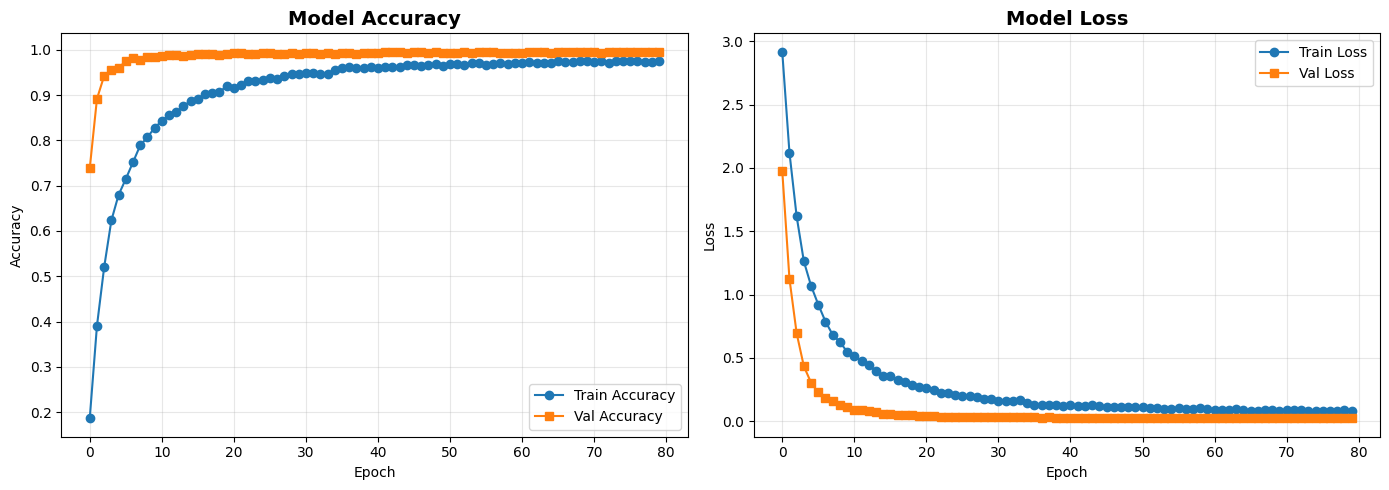

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

print("HASIL TRAINING")
print(f"Total Epoch Dijalankan: {len(history.history['accuracy'])}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"\nFinal Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

HASIL TRAINING
Total Epoch Dijalankan: 80
Best Epoch: 44
Best Validation Accuracy: 0.9958 (99.58%)

Final Training Accuracy: 0.9758 (97.58%)
Final Validation Accuracy: 0.9958 (99.58%)
Final Training Loss: 0.0798
Final Validation Loss: 0.0227


In [ ]:
checkpoint_path = '/content/drive/MyDrive/ngaksara/model/best.h5'

print("Loading best model...")
best_model = load_model(checkpoint_path)
print(f"✓ Best model loaded dari: {checkpoint_path}")
print(f"  - best.h5 ({os.path.getsize(checkpoint_path) / (1024 * 1024):.2f} MB)")

Loading best model...


✓ Best model loaded dari: /content/drive/MyDrive/ngaksara/model/best.h5
  - best.h5 (130.16 MB)


In [ ]:
print("EVALUASI PADA TEST SET")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

EVALUASI PADA TEST SET
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 444ms/step - accuracy: 0.9902 - loss: 0.0287

Test Loss: 0.0191
Test Accuracy: 0.9940 (99.40%)


In [ ]:
print("\nGenerating test predictions for detailed metrics...")
test_generator.reset()

y_test_pred = best_model.predict(test_generator, verbose=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = test_generator.classes

class_names = list(train_generator.class_indices.keys())

print(f"✓ Total test predictions: {len(y_test_pred_classes)}")
print(f"✓ Total test true labels: {len(y_test_true)}")


Generating test predictions for detailed metrics...
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step
✓ Total test predictions: 1500
✓ Total test true labels: 1500


In [ ]:
report = classification_report(y_test_true, y_test_pred_classes,
                               target_names=class_names,
                               digits=4)

print("CLASSIFICATION REPORT (TEST SET)")
print(report)

accuracy = accuracy_score(y_test_true, y_test_pred_classes)
precision = precision_score(y_test_true, y_test_pred_classes, average='weighted')
recall = recall_score(y_test_true, y_test_pred_classes, average='weighted')
f1 = f1_score(y_test_true, y_test_pred_classes, average='weighted')

print("OVERALL TEST METRICS:")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

           a     0.9434    1.0000    0.9709        50
          ae     1.0000    0.9400    0.9691        50
          ba     1.0000    0.9800    0.9899        50
          ca     1.0000    1.0000    1.0000        50
          da     1.0000    0.9800    0.9899        50
           e     1.0000    1.0000    1.0000        50
          eu     1.0000    1.0000    1.0000        50
          fa     1.0000    1.0000    1.0000        50
          ga     1.0000    1.0000    1.0000        50
          ha     0.9615    1.0000    0.9804        50
           i     1.0000    1.0000    1.0000        50
          ja     0.9804    1.0000    0.9901        50
          ka     1.0000    1.0000    1.0000        50
          la     1.0000    1.0000    1.0000        50
          ma     1.0000    1.0000    1.0000        50
          na     1.0000    1.0000    1.0000        50
         nga     1.0000    1.0000    1.0000     

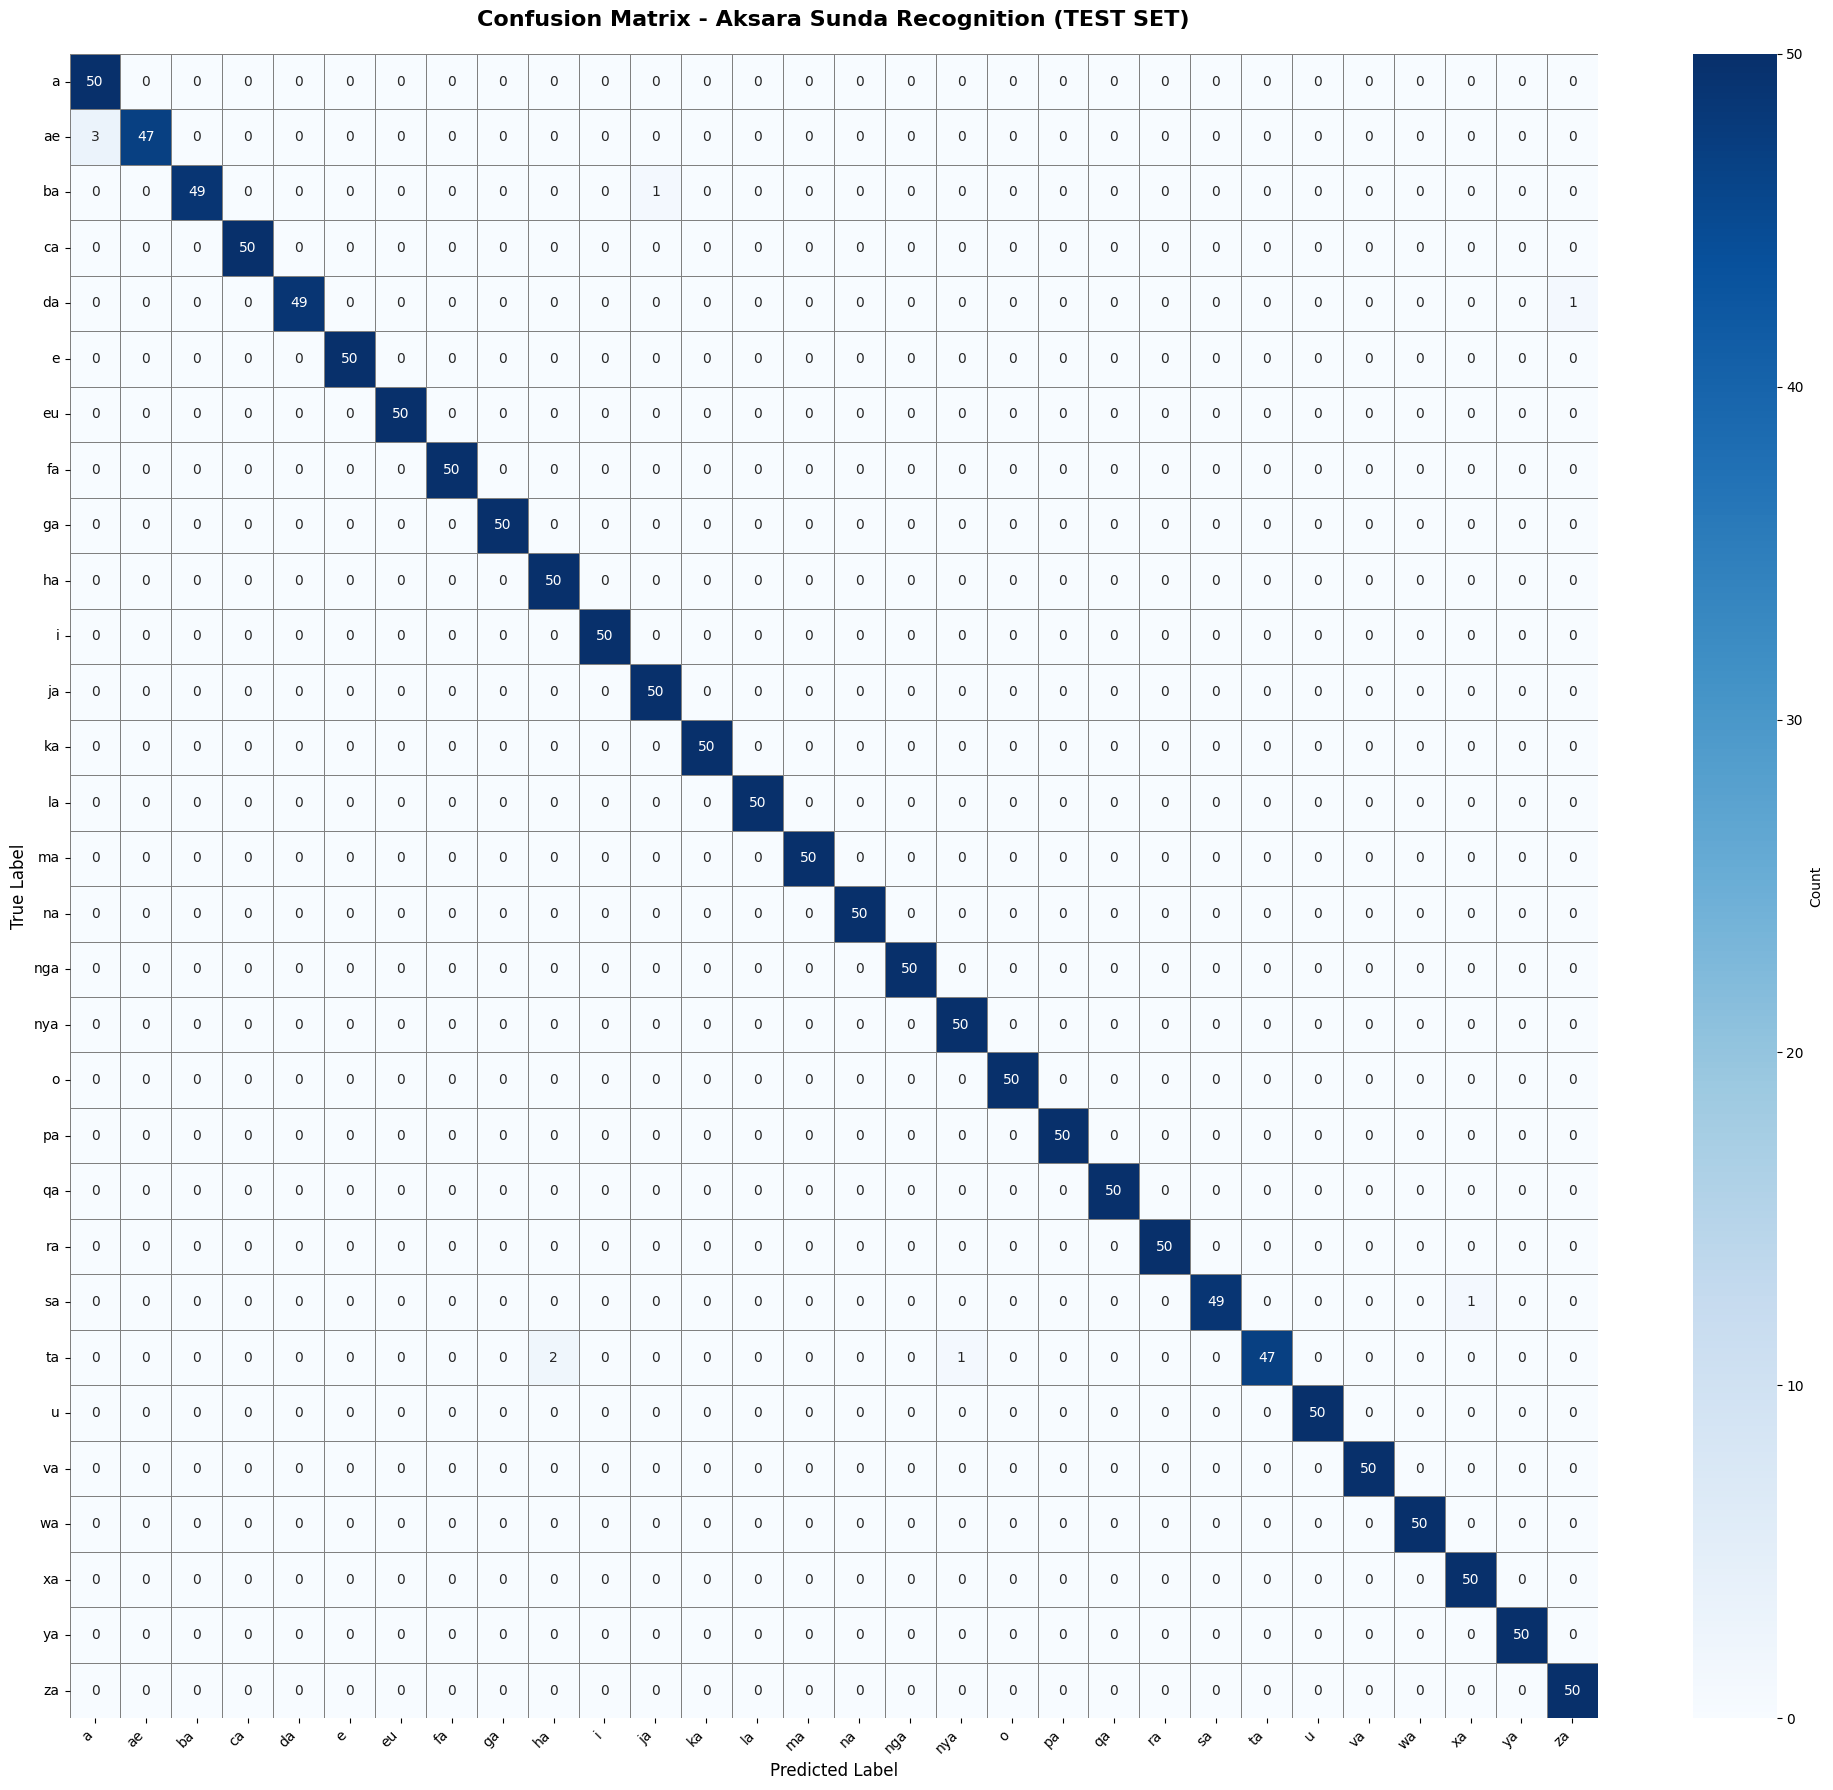

ACCURACY PER CLASS (TEST SET):
a              : 1.0000 (100.00%)
ae             : 0.9400 (94.00%)
ba             : 0.9800 (98.00%)
ca             : 1.0000 (100.00%)
da             : 0.9800 (98.00%)
e              : 1.0000 (100.00%)
eu             : 1.0000 (100.00%)
fa             : 1.0000 (100.00%)
ga             : 1.0000 (100.00%)
ha             : 1.0000 (100.00%)
i              : 1.0000 (100.00%)
ja             : 1.0000 (100.00%)
ka             : 1.0000 (100.00%)
la             : 1.0000 (100.00%)
ma             : 1.0000 (100.00%)
na             : 1.0000 (100.00%)
nga            : 1.0000 (100.00%)
nya            : 1.0000 (100.00%)
o              : 1.0000 (100.00%)
pa             : 1.0000 (100.00%)
qa             : 1.0000 (100.00%)
ra             : 1.0000 (100.00%)
sa             : 0.9800 (98.00%)
ta             : 0.9400 (94.00%)
u              : 1.0000 (100.00%)
va             : 1.0000 (100.00%)
wa             : 1.0000 (100.00%)
xa             : 1.0000 (100.00%)
ya             : 1.000

In [ ]:
cm = confusion_matrix(y_test_true, y_test_pred_classes)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Confusion Matrix - Aksara Sunda Recognition (TEST SET)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("ACCURACY PER CLASS (TEST SET):")
for i, acc in enumerate(class_accuracy):
    print(f"{class_names[i]:15s}: {acc:.4f} ({acc*100:.2f}%)")

In [ ]:
print("\nTOP 10 MOST CONFUSED CLASSES (TEST SET):")
confused_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i][j] > 0:
            confused_pairs.append((class_names[i], class_names[j], cm[i][j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)

for idx, (true_class, pred_class, count) in enumerate(confused_pairs[:10], 1):
    print(f"{idx:2d}. {true_class:15s} → {pred_class:15s}: {count:3d} times")


TOP 10 MOST CONFUSED CLASSES (TEST SET):
 1. ae              → a              :   3 times
 2. ta              → ha             :   2 times
 3. ba              → ja             :   1 times
 4. da              → za             :   1 times
 5. sa              → xa             :   1 times
 6. ta              → nya            :   1 times


In [ ]:
print("RINGKASAN HASIL")
print(f"Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

RINGKASAN HASIL
Training Accuracy:   0.9758 (97.58%)
Validation Accuracy: 0.9958 (99.58%)
Test Accuracy:       0.9940 (99.40%)
